In [1]:
import numpy as np
import networkx as nx
import yaml
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Some useful functions:
- `bin_particles`
- `plot_particles_in_nodes`
- `simulate`
- `particles_in_nodes_local_poisson` : this is the only function slightly modified respect to the previuous exercise:
    - Now the starting node has infinite particles.
    - The rate from the starting_node to 'o' (lambda) can be changed, with the parameter `in_rate`.
    - we add the attribute `in_rate_node`, used, with `start_node`, to modify the `in_rate`.

- `particles_in_nodes_global_poisson_modified`: to solve the exercise with fixed rate.

This is very similar to the theory. You can find it at page 156 of book.

In [2]:
def bin_particles(particles, time, time_range):
    """Bin the particles according to the new timesteps described in time_range.

    Parameters
    ----------
    particles : list
        The list of particles of one single simulation.
    time : list
        The list of time of one single simulation.
    time_range : np.array
        The list of new timesteps to bin the particles.

    Returns
    -------
    particles : numpy.ndarray
        The binned particles.
    """
    particles = np.array(particles)
    # take indices of time according to time_range
    indices = np.digitize(time_range, time)

    particles = particles[indices-1]
    return particles

def plot_particles_in_nodes(nodes, acc_particles, acc_time, stop_time=60, num_bins=1000, title='Number of Particles in Each Node'):
    """
    Plot the number of particles in each node over time.

    Parameters
    ----------
    nodes : list
        The list of node names.
    acc_particles : list
        The list of particles in each node.
    acc_time : list
        The list of time.
    stop_time : int, optional
        The stopping time, by default 60.
    num_bins : int, optional
        The number of bins for time range, by default 1000.
    """
    time_range = np.linspace(0, stop_time, num_bins)

    particles = [bin_particles(p, t, time_range) for p, t in zip(acc_particles, acc_time)]
    particles = np.array(particles).mean(axis=0)

    plt.figure(figsize=(10, 6))
    for i, node in enumerate(nodes):
        plt.plot(time_range, particles[:, i], label=node)
    plt.xlabel('Time')
    plt.ylabel('Number of Particles')
    plt.title(title)
    plt.legend()
    plt.show()

def particles_in_nodes_local_poisson(W, start_node, end_node, in_rate_node, in_rate=1, stop_time=60, fixed_rate=False):
    """Simulate the behaviour of particles in nodes.
    We use a local poisson process for each node. 
    This choice among all the possible ones is discussed in the appendix of the previous exercise.
    The main reason is a better efficiency, with the same accuracy.

    - The start_node has always one particle (we do not decrease the particles in it), so virtually it has infinite particles.
    - The end_node has always zero particles (we do not increase the particles in it), so it never ticks. This is what we want.
    - The rate of particles popping in node 'o' can be changed, with in_rate = int.  
    - The rates can be fixed, and do not change with the population, with fixed_rate = True.

    To simulate the behaviour of the particles also in fixed rate, we changed some behaviours:
    - In fixed_rate we use a scale of 1/(rate*particles>0), instead of 1/(rates*particles).
    - Now, this is the chosen node ticking time: ticking_time = np.random.exponential(scale) instead of the old ticking_time = min(old_tick_time, np.random.exponential(scale))

    Why?
    Because in the old case, the ticking time would have been influenced by the number of particles.

    We hope to be clear, more in the appendix.

    Args:
        W (np.array): transition rate matrix
        start_node (int): starting node index
        end_node (int): ending node index
        in_rate_node (int): node index where the particles enter
        in_rate (int, optional): rate of the starting node. Defaults to 1.
        stop_time (int, optional): time to stop the simulation. Defaults to 60.
        fixed_rate (bool, optional): if the rate is fixed or not.

    Returns:
        particles (np.array): number of particles in each node at the end of the simulation
        acc_particles (list): list of particles in each node at each tick
        acc_time (list): list of times at each tick
    """
    # Modify in_rate.
    W[start_node][in_rate_node] = in_rate
    # Calculate rates and scales.
    rates = W.sum(axis=1)
    scales = 1/rates
    # Calculate P.
    P = np.linalg.inv(np.diag(rates)) @ W
    # Initialize particles in each node.
    particles = np.zeros((P.shape[0]))
    particles[start_node] = 1
    
    # Initialize the results and time.
    time = 0
    acc_particles = [particles.copy()]
    acc_time = [time]

    # Function which calculate the new scale for the two involved nodes.
    if fixed_rate:
        tick_times = np.random.exponential(scales/(particles>0))
        scale_fn = lambda s, p, t:  s[t]/(p[t]>0)
    else:
        tick_times = np.random.exponential(scales/particles)
        scale_fn = lambda s, p, t:  s[t]/p[t]

    while time < stop_time:
        # Find the index of the minimum
        ticking_node = np.argmin(tick_times)
        # Find the minimum
        min_tick_time = tick_times[ticking_node]
        # select the chosen node
        chosen_node = np.random.choice(P.shape[0], p=P[ticking_node])

        # update the particles
        if ticking_node != start_node:
            particles[ticking_node] -= 1

        # If the chosen node is the end one, we don't want to update it:
        # Accumulating particles could lead to ticking problems. This is just a try.
        # Without particles, the scale is infinite, so the node never ticks. (That's what we want)
        if chosen_node != end_node:
            particles[chosen_node] += 1

        # update the time
        time += min_tick_time
        # update the tick times
        tick_times -= min_tick_time

        # calculate the new scale for the ticking node
        scale = scale_fn(scales, particles, ticking_node)

        # update the tick time of the ticking node
        tick_times[ticking_node] = np.random.exponential(scale)

        # calculate the new scale for the chosen node
        scale = scale_fn(scales, particles, chosen_node)

        # update the tick time of the chosen node
        tick_times[chosen_node] = np.random.exponential(scale)

        # append particles and time
        acc_particles.append(particles.copy())
        acc_time.append(time)
    
    return particles, acc_particles, acc_time

def particles_in_nodes_global_poisson_modified(W, start_node, end_node, in_rate_node, in_rate=1, num_particles=100, stop_time=60):
    """Simulate the number of particles in each node, using a global Poisson process with fixed rate.
    This version is very similar to the one suggested by professors.
    1. We use a global poisson process with rate 100, to simulate the ticks.
    2. We select the node that ticks, considering the amount of particles in each node as probabilities.
    3. We select the node chosen by the particle, considering the transition probabilities of P_bar.

    Args:
        W (np.array): transition rate matrix
        start_node (int): starting node index
        end_node (int): ending node index
        in_rate_node (int): node index where the particles enter
        in_rate (int, optional): rate of the starting node. Defaults to 1.
        num_particles (int, optional): number of particles in the system. Defaults to 100.
        stop_time (int, optional): time to stop the simulation. Defaults to 60.

    Returns:
        particles (np.array): number of particles in each node at the end of the simulation
        acc_particles (list): list of particles in each node at each tick
        acc_time (list): list of times at each tick
    """
    # Modify W with the in_rate.
    W[start_node][in_rate_node] = in_rate
    # calculate rates
    rates = W.sum(axis=1)
    # calculate the max rate
    max_rate = rates.max()
    # calculate the probability transition matrix: P_bar
    P_bar = W/max_rate
    P_bar += np.eye(P_bar.shape[0]) - np.diag(P_bar.sum(axis=1))
    # initialize particles in each node
    particles = np.zeros(P_bar.shape[0], dtype=int)
    particles[start_node] = num_particles
    # initialize the results and time
    time = 0
    acc_time = [time]
    acc_particles = [particles.copy()]
    
    # calculate the ticking prob for each node:
    # and  the global scale for the global poisson process
    global_scale = 1/max_rate
    tick_probs = lambda p: np.int64(p>0)/sum(p>0)

    while time < stop_time:
        # this is the global poisson clock, with rate = num_particles
        t_next = np.random.exponential(global_scale)
        time += t_next
        # randomly choose the starting node
        ticking_node = np.random.choice(P_bar.shape[0], p=tick_probs(particles))
        # choose the next node
        chosen_node = np.random.choice(P_bar.shape[0], p=P_bar[ticking_node])
        # update particles
        if ticking_node != start_node:
            particles[ticking_node] -= 1
        if chosen_node != end_node:
            particles[chosen_node] += 1
        # store the results
        acc_particles.append(particles.copy())
        acc_time.append(time)

    return particles, acc_particles, acc_time

def simulate(num_simulations, config, function):
    """run simulations.

    Args:
        num_simulations (int): number of simulations
        config (dict): configuration
        function (function): function to simulate

    Returns:
        particles (list): list of particles in each node at the end of each simulation
        acc_particles (list): list of particles in each node at each time step
        acc_time (list): list of time at each time step
    """
    # initialize the results
    particles = []
    acc_particles = []
    acc_time = []
    for _ in tqdm(range(num_simulations)):
        # simulate the particles
        ps, acc_ps, acc_tm = function(**config)
        # store the results
        particles.append(ps)
        acc_particles.append(acc_ps)
        acc_time.append(acc_tm)
    return particles, acc_particles, acc_time  

# Data
Here the data is stored in a `config.yaml` file, just for fun.

In [3]:
# data:

# load yaml file
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

nodes = config['nodes']
W = np.array(config['t_rate'])

# print the transition rate matrix and the nodes
print('Nodes:')
print(nodes)
print('Transition rate:')
print(W)

Nodes:
['o', 'a', 'b', 'c', 'd']
Transition rate:
[[0.   0.75 0.75 0.   0.  ]
 [0.   0.   0.25 0.25 0.5 ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.  ]]


# Create The graph

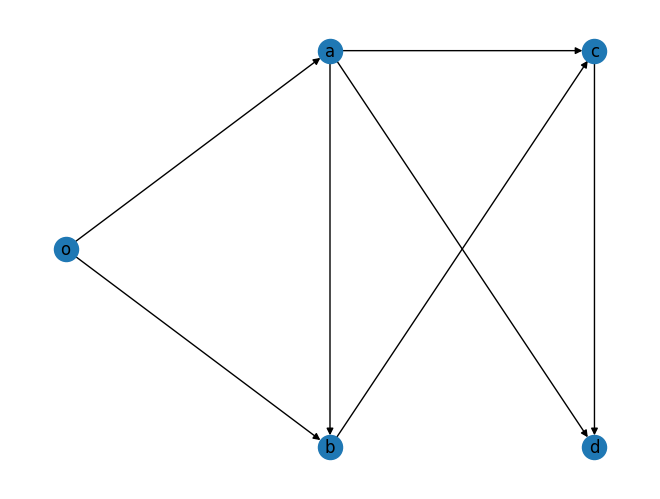

In [4]:
# create graph
G = nx.DiGraph(W)

# relabel nodes
mapping = {i: nodes[i] for i in range(len(nodes))}
G = nx.relabel_nodes(G, mapping)

# draw graph
pos = {'o': (0,0), 'a': (1,1), 'b': (1,-1), 'c': (2,1), 'd': (2,-1)}
nx.draw(G, with_labels=True, pos=pos)

# Update the graph:
We add **source (s)** adn **sink (t)**.

the rate between (s) and (o) is 1, but it will be changed later.

the rate between (d) and (t) is 2, and it is fixed.

Moreover, there is a self-loop on (t) with rate 1, in order to simplify the computations.

We added a source and a sink to the graph.
The source has only one outgoing edge with rate 1.
The sink has one ingoing edge with rate 2, and one self-loop edge with rate 1.
The self-loop edge is used to allow the inverse of D to be computed.

The in_rate parameter of the simulate_particles function can be used to change
the rate of the source.


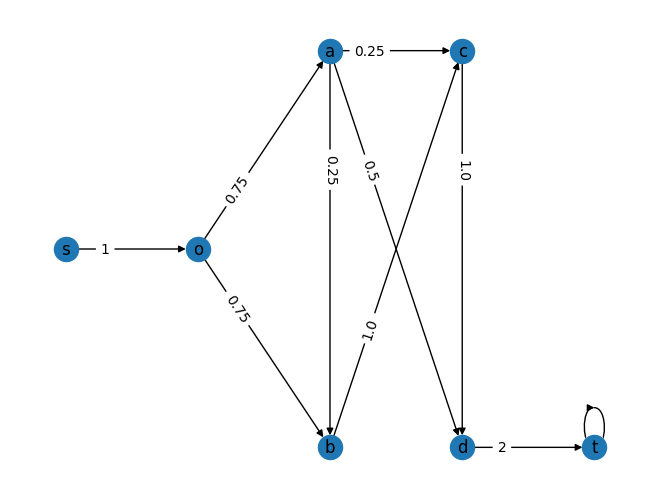

In [5]:
# define the new edges:
# the in rate is fixed to 1, but in the function to simulate
# the behaviour of particles in nodes, it can be changed
# by changing in_rate == lambda
edges = [
    ('s','o', 1), 
    ('d','t', 2), 
    ('t', 't', 1) # self loop to make t_rate invertible
]

# define the new pos:
pos['s'] = (-1,0)
pos['t'] = (3,-1)

# add edges
G.add_weighted_edges_from(edges)

# retrieve nodes and map them to indices
nodes = list(G.nodes())
node_to_index = {nodes[i]: i for i in range(len(nodes))}

# calculate new t_rate
W = nx.adjacency_matrix(G).toarray()

# draw graph
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, with_labels=True, pos=pos)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, label_pos=0.7)

print(
"""We added a source and a sink to the graph.
The source has only one outgoing edge with rate 1.
The sink has one ingoing edge with rate 2, and one self-loop edge with rate 1.
The self-loop edge is used to allow the inverse of D to be computed.

The in_rate parameter of the simulate_particles function can be used to change
the rate of the source."""
)

# point a.1


Configuration:
start_node: s
end_node: t
in_rate: 100
stop_time: 60
Number of simulations: 100


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


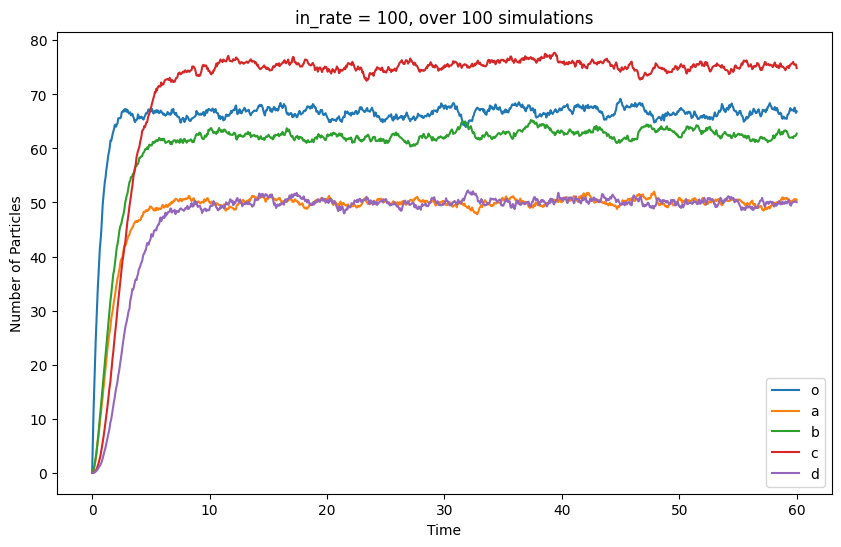

In [6]:
# config for the simulation:
config  = {
    'W': W,
    'start_node': node_to_index['s'],
    'end_node': node_to_index['t'],
    'in_rate_node': node_to_index['o'],
    'in_rate': 100,
    'stop_time': 60,
}

# number of simulations
num_simulations = 100

# print the results's configuration
print()
print('Configuration:')
print(f"start_node: {nodes[config['start_node']]}")
print(f"end_node: {nodes[config['end_node']]}")
print(f"in_rate: {config['in_rate']}")
print(f"stop_time: {config['stop_time']}")
print(f'Number of simulations: {num_simulations}')

# simulate
with np.errstate(divide='ignore'):
    particles, acc_particles, acc_time = simulate(num_simulations, config, particles_in_nodes_local_poisson)

# plot the results
plot_particles_in_nodes(nodes[:-2], acc_particles, acc_time, stop_time=config['stop_time'], title='in_rate = 100, over 100 simulations')

# point a.2

In [7]:
# Basically, there is a breaking point in which the particles in the nodes are
# too many, and the simulation takes too long, because the scale is too small.

# Particles start to move too fast, 
# time becomes to little, 
# 60 time units become eternity.

# When the in_rate is very high, the particles in the source are a lot, 
# but they can flow at a very high rate, because the rate is proportional to the 
# number of particles in the nodes.
# For these reasons, better explained in the report, the sistem never explodes.

# point b.1


Configuration:
start_node: s
end_node: t
in_rate: 1
stop_time: 60
num_simulations: 1000


  1%|          | 12/1000 [00:00<00:50, 19.56it/s]

100%|██████████| 1000/1000 [00:17<00:00, 55.71it/s]


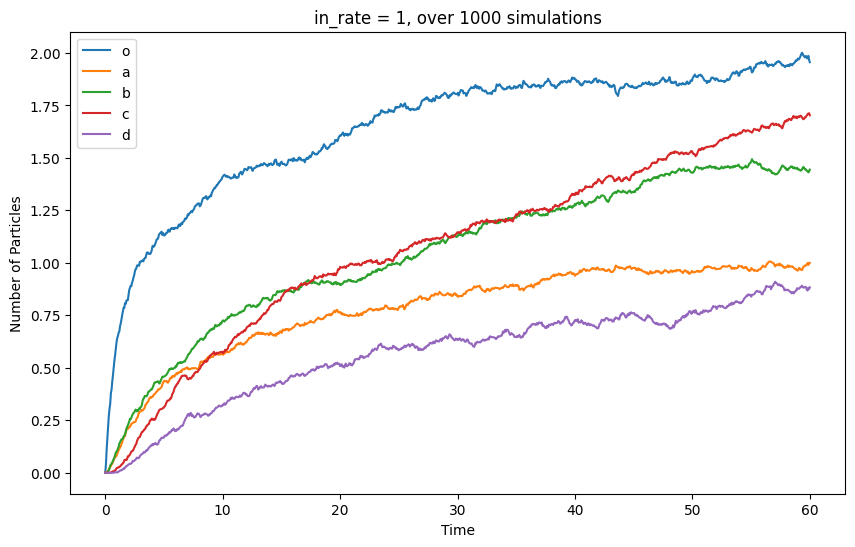

In [8]:
# config for the simulation:
config  = {
    'W': W,
    'start_node': node_to_index['s'],
    'end_node': node_to_index['t'],
    'in_rate': 1,
    'in_rate_node': node_to_index['o'],
    'stop_time': 60,
}

# number of simulations: the more, the better.
num_simulations = 1000

# print the results's configuration
print()
print('Configuration:')
print(f"start_node: {nodes[config['start_node']]}")
print(f"end_node: {nodes[config['end_node']]}")
print(f"in_rate: {config['in_rate']}")
print(f"stop_time: {config['stop_time']}")
print(f"num_simulations: {num_simulations}")

# simulate
with np.errstate(divide='ignore'):
    particles, acc_particles, acc_time = simulate(num_simulations, config, particles_in_nodes_global_poisson_modified)
    
# plot the results
plot_particles_in_nodes(nodes[:-2], acc_particles, acc_time, stop_time=config['stop_time'], title='in_rate = 1, over 1000 simulations')

# point b.2

In [9]:
# Here the rates are fixed, so if we increment the in_rate, the rate
# between (s) and (o), over a certain value, the system explodes.

# This happens because the the nodes' rates are no more proportional to the
# number of particles in the nodes, so the particles can't flow fast enough.

# there are two principal bottleneck:
# 1. the rate between (c) and (d).
# 2. the rate between (o) and the rest of the graph.

# It is clear when we compare the tendency of in_rate=1.3 and in_rate=1.4, with a sufficent time,
# averaging over at least 100 simulations.
# More on the report.

# config for the simulation:
config1  = {
    'W': W,
    'start_node': node_to_index['s'],
    'end_node': node_to_index['t'],
    'in_rate': 1.3,
    'in_rate_node': node_to_index['o'],
    'stop_time': 6000,
}
config2 = config1.copy()
config2['in_rate'] = 1.4

# number of simulations: 10 to be faster, 100 to be more accurate
num_simulations = 100

# simulate
with np.errstate(divide='ignore'):
    _, acc_particles1, acc_time1 = simulate(num_simulations, config1, particles_in_nodes_global_poisson_modified)
    _, acc_particles2, acc_time2 = simulate(num_simulations, config2, particles_in_nodes_global_poisson_modified)


100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


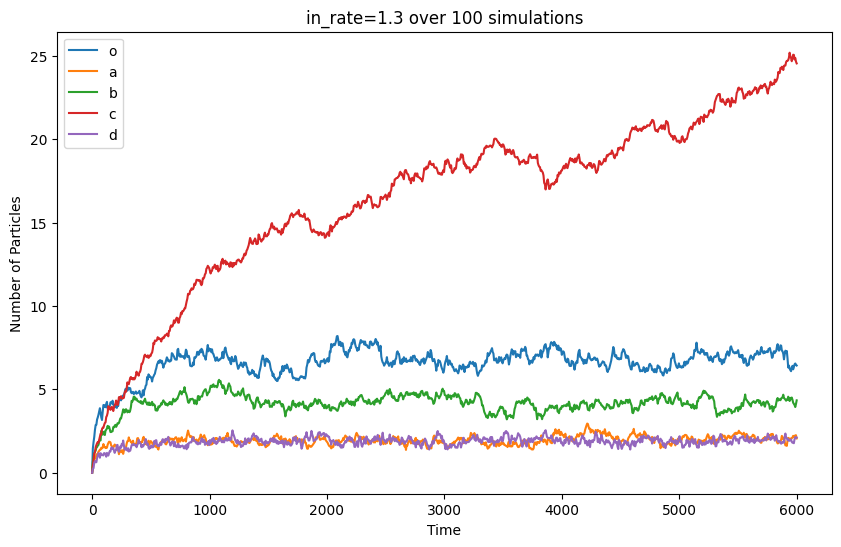

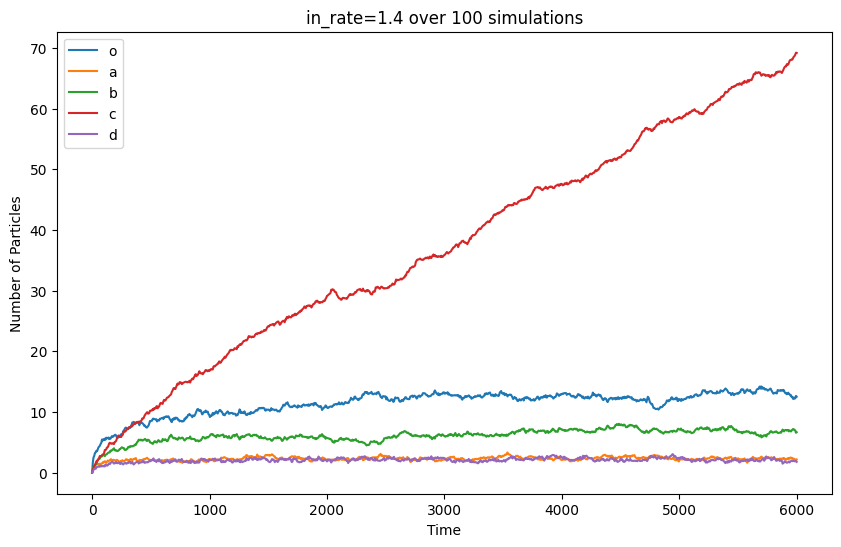

In [10]:
# the simulations go on for 6000 time units.
stop_time = config1['stop_time']
# Inside this interval of time, we take 1000 instants.
num_bins = 1000

plot_particles_in_nodes(nodes[:-2], acc_particles1, acc_time1, stop_time=stop_time, num_bins=num_bins, title='in_rate=1.3 over 100 simulations')
plot_particles_in_nodes(nodes[:-2], acc_particles2, acc_time2, stop_time=stop_time, num_bins=num_bins, title='in_rate=1.4 over 100 simulations')

# Appendix


To solve the dynamic of the graph in **fixed rate**, we used the solution proposed in the book: `nodes_in_particles_global_poisson_modified`.

### nodes_in_particles_global_poisson_modified
From the book, at page 156, it is described an approximation of a continuous time Markov-chain random walk.
- **P_bar**: transition probability matrix with diagonal > 0. (Particles can remain in node, like a self-loop).
- **Global Poisson clock**, with rate fixed at max_rate, the maximum rate you can find among nodes in the graph.
- **uniform probability** for each node to be selected when the clock ticks. Of course among nodes with at least one particle.

### A variant of the local Poisson
To be coherent with the work done before, we also slightly modified our original function: `nodes_in_particles_local_poisson`, to adapt it to a fixed rate scenario (how it is decribed in the description of function), and will now test our thesis with it too.

The **thesis** is that with a $\lambda > 1.33$ the system explodes, in particular, particles start to **accumulate** in $c$.

### Results & conclusions
This experiment below show that our function, with a local poisson clock attached to each node, works well, and show the exploding dynamic with the same threshold of 1.33.

The **main difference** is that it has **faster dynamics**. We believe that this is because of a more **realistic** modeling, without the absolute static approximation of having fixed rate of global poisson at **max_rate**.

We decided to use the one with the fixed global poisson to spare some time. As a matter of fact, having faster dynamics means that simulating it for 6000 time units takes more time.

100%|██████████| 100/100 [05:12<00:00,  3.13s/it]


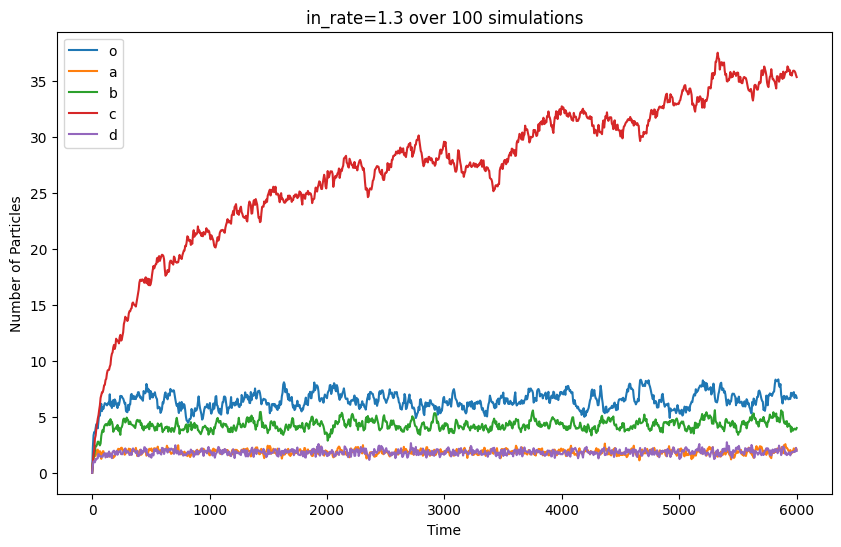

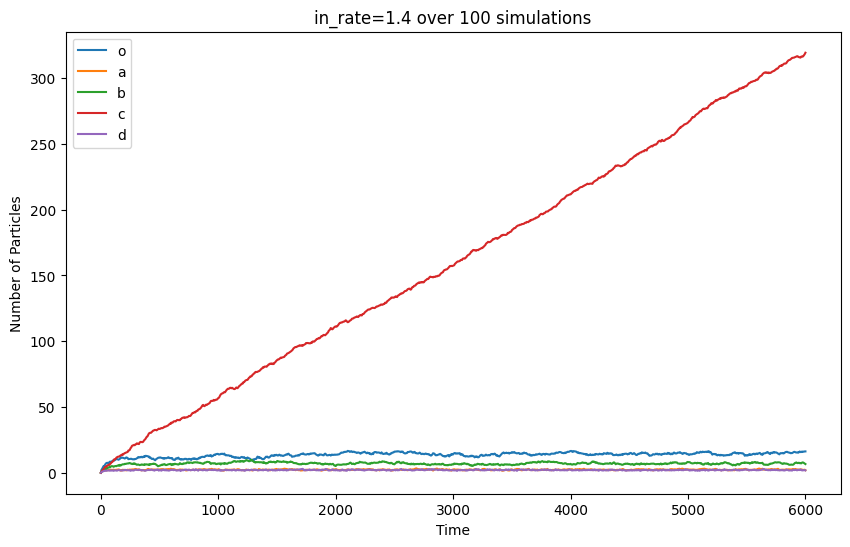

In [11]:
# It is clear when we compare the tendency of in_rate=1.3 and in_rate=1.4, with a sufficent time,
# averaging over at least 100 simulations.
# More on the report.

# config for the simulation:
config1  = {
    'W': W,
    'start_node': node_to_index['s'],
    'end_node': node_to_index['t'],
    'in_rate': 1.3,
    'in_rate_node': node_to_index['o'],
    'stop_time': 6000,
    'fixed_rate': True,
}
config2 = config1.copy()
config2['in_rate'] = 1.4

# number of simulations: 10 to be faster, 100 to be more accurate
num_simulations = 100

# simulate
with np.errstate(divide='ignore'):
    _, acc_particles1, acc_time1 = simulate(num_simulations, config1, particles_in_nodes_local_poisson)
    _, acc_particles2, acc_time2 = simulate(num_simulations, config2, particles_in_nodes_local_poisson)

# The stop time is 600, because the simulations go on for 5000 time units.
stop_time = config1['stop_time']
# Inside this interval of time, we take 1000 instants.
num_bins = 1000

plot_particles_in_nodes(nodes[:-2], acc_particles1, acc_time1, stop_time=stop_time, num_bins=num_bins, title='in_rate=1.3 over 100 simulations')
plot_particles_in_nodes(nodes[:-2], acc_particles2, acc_time2, stop_time=stop_time, num_bins=num_bins, title='in_rate=1.4 over 100 simulations')